In [1]:
from tensorflow import lite
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import random, os
import shutil
import matplotlib.pyplot as plt
from matplotlib.image import imread
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import categorical_accuracy
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNet
from imblearn.over_sampling import SMOTE
from sklearn.datasets import make_classification
from collections import Counter

In [2]:
# Add an additional column, mapping to the type
df = pd.read_csv(r'dataset/train.csv')

diagnosis_dict_binary = {
    0: 'No_DR',
    1: 'DR',
    2: 'DR',
    3: 'DR',
    4: 'DR'
}

diagnosis_dict = {
    0: 'No_DR',
    1: 'Mild',
    2: 'Moderate',
    3: 'Severe',
    4: 'Proliferate_DR',
}

df['binary_type'] =  df['diagnosis'].map(diagnosis_dict_binary.get)
df['type'] = df['diagnosis'].map(diagnosis_dict.get)
df.head()

,id_code,diagnosis,binary_type,type
0,000c1434d8d7,2,DR,Moderate
1,001639a390f0,4,DR,Proliferate_DR
2,0024cdab0c1e,1,DR,Mild
3,002c21358ce6,0,No_DR,No_DR
4,005b95c28852,0,No_DR,No_DR


<Axes: ylabel='type'>

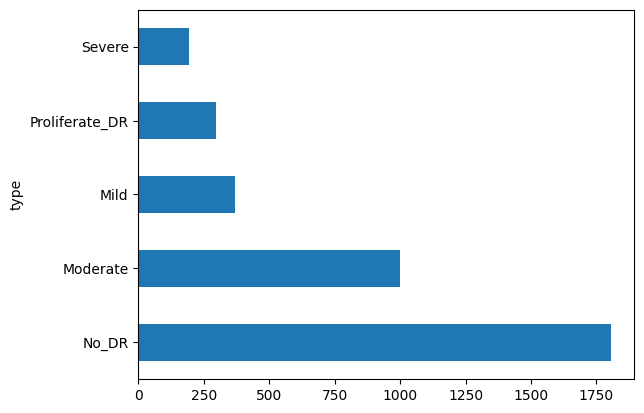

In [3]:
df['type'].value_counts().plot(kind='barh')

<Axes: ylabel='binary_type'>

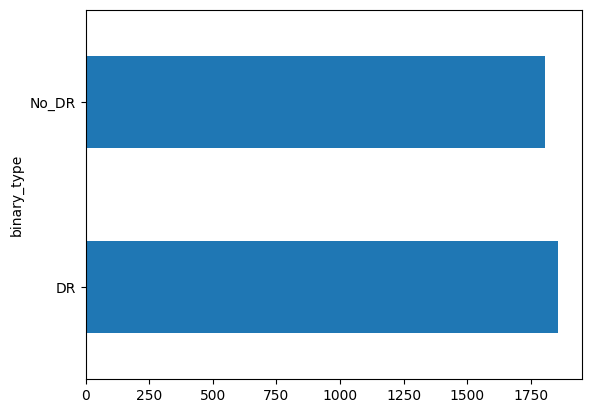

In [4]:
df['binary_type'].value_counts().plot(kind='barh')

In [5]:
# Split into stratified train, val, and test sets
train_intermediate, val = train_test_split(df, test_size = 0.15, stratify = df['type'])
train, test = train_test_split(train_intermediate, test_size = 0.15 / (1 - 0.15), stratify = train_intermediate['type'])

print(train['type'].value_counts(), '\n')
print(test['type'].value_counts(), '\n')
print(val['type'].value_counts(), '\n')

type
No_DR             1263
Moderate           699
Mild               258
Proliferate_DR     207
Severe             135
Name: count, dtype: int64 

type
No_DR             271
Moderate          150
Mild               56
Proliferate_DR     44
Severe             29
Name: count, dtype: int64 

type
No_DR             271
Moderate          150
Mild               56
Proliferate_DR     44
Severe             29
Name: count, dtype: int64 



In [6]:
X = df[['id_code']] 
y = df['diagnosis']

In [7]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
if X['id_code'].dtype == 'object': 
    X['id_code'] = label_encoder.fit_transform(X['id_code'])

print(X.head())

   id_code
0        0
1        1
2        2
3        3
4        4


C:\Users\RESTU\AppData\Local\Temp\ipykernel_40048\4277947033.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['id_code'] = label_encoder.fit_transform(X['id_code'])


In [8]:
# Create working directories for train/val/test
base_dir = 'data/'

train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

if os.path.exists(base_dir):
    shutil.rmtree(base_dir)

if os.path.exists(train_dir):
    shutil.rmtree(train_dir)
os.makedirs(train_dir)

if os.path.exists(val_dir):
    shutil.rmtree(val_dir)
os.makedirs(val_dir)

if os.path.exists(test_dir):
    shutil.rmtree(test_dir)
os.makedirs(test_dir)

In [9]:
src_dir = r'dataset/diabetic-retinopathy-224x224-gaussian-filtered'
for index, row in train.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(train_dir, diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)

for index, row in val.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(val_dir, diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)
 
for index, row in test.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(test_dir, diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)

Distribusi kelas sebelum SMOTE:
diagnosis
0    1805
2     999
1     370
4     295
3     193
Name: count, dtype: int64

Distribusi kelas setelah SMOTE:
diagnosis
2    1805
4    1805
1    1805
0    1805
3    1805
Name: count, dtype: int64


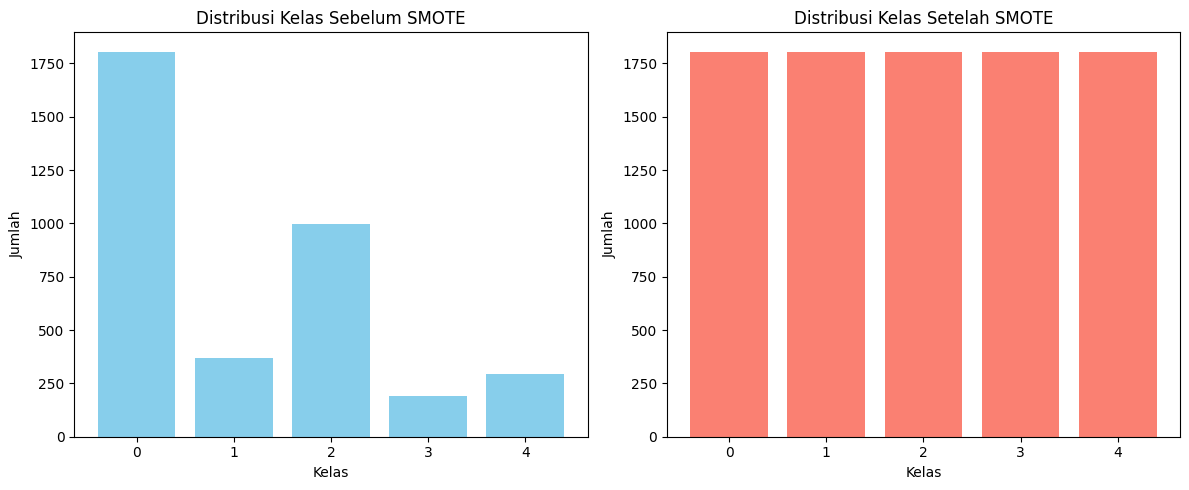

In [10]:
# Menampilkan distribusi sebelum SMOTE
print("Distribusi kelas sebelum SMOTE:")
print(pd.Series(y).value_counts())

# Terapkan SMOTE
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

# Menampilkan distribusi setelah SMOTE
print("\nDistribusi kelas setelah SMOTE:")
print(pd.Series(y_res).value_counts())

# Visualisasi distribusi
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Plot distribusi sebelum SMOTE
ax[0].bar(Counter(y).keys(), Counter(y).values(), color='skyblue')
ax[0].set_title("Distribusi Kelas Sebelum SMOTE")
ax[0].set_xlabel("Kelas")
ax[0].set_ylabel("Jumlah")

# Plot distribusi setelah SMOTE
ax[1].bar(Counter(y_res).keys(), Counter(y_res).values(), color='salmon')
ax[1].set_title("Distribusi Kelas Setelah SMOTE")
ax[1].set_xlabel("Kelas")
ax[1].set_ylabel("Jumlah")

plt.tight_layout()
plt.show()


In [11]:
# Setting up ImageDataGenerator for train/val/test 

train_path = 'data/train'
val_path = 'data/val'
test_path = 'data/test'

train_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(train_path, target_size=(224,224), shuffle = True)
val_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(val_path, target_size=(224,224), shuffle = True)
test_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(test_path, target_size=(224,224), shuffle = False)

Found 2562 images belonging to 5 classes.
Found 550 images belonging to 5 classes.
Found 550 images belonging to 5 classes.


In [12]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNet

# Load pre-trained MobileNet model without the top layer
base_model = MobileNet(input_shape=(224, 224, 3),
                       include_top=False,  # Exclude the top layer
                       weights='imagenet')  # Pre-trained on ImageNet

# Freeze the base model
base_model.trainable = False

# Build the model
model = tf.keras.Sequential([
    base_model,  # Pre-trained MobileNet backbone
    layers.GlobalAveragePooling2D(),  # Pooling layer to reduce dimensions
    layers.Dense(64, activation='relu'),  # Fully connected layer
    layers.Dropout(0.2),  # Dropout for regularization
    layers.Dense(5, activation='softmax')  # Output layer for 5 classes
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',  # Use for multi-class classification
              metrics=['accuracy'])

# Train the model
history = model.fit(train_batches,
                    epochs=50,
                    validation_data=val_batches)

# Evaluate the model
test_loss, test_acc = model.evaluate(test_batches)
print(f"Test Accuracy: {test_acc:.2f}")

C:\Users\RESTU\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 63s 728ms/step - accuracy: 0.4197 - loss: 1.5124 - val_accuracy: 0.7036 - val_loss: 0.9095
Epoch 2/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 26s 315ms/step - accuracy: 0.6509 - loss: 0.9517 - val_accuracy: 0.7255 - val_loss: 0.7880
Epoch 3/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 26s 314ms/step - accuracy: 0.7158 - loss: 0.7954 - val_accuracy: 0.7291 - val_loss: 0.7441
Epoch 4/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 26s 321ms/step - accuracy: 0.7278 - loss: 0.7505 - val_accuracy: 0.7418 - val_loss: 0.7152
Epoch 5/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 26s 319ms/step - accuracy: 0.7532 - loss: 0.7123 - val_accuracy: 0.7509 - val_loss: 0.6960
Epoch 6/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 26s 318ms/step - accuracy: 0.7363 - loss: 0.7140 - val_accuracy: 0.7473 - val_loss: 0.6798
Epoch 7/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 26s 314ms/step - accuracy: 0.7506 - loss: 0.6798 - val_accuracy: 0.7582 - val_loss: 0.6686
Epoch 8/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 26s 321ms/step - accuracy: 0.7720 - loss: 0.6482 - val_accu

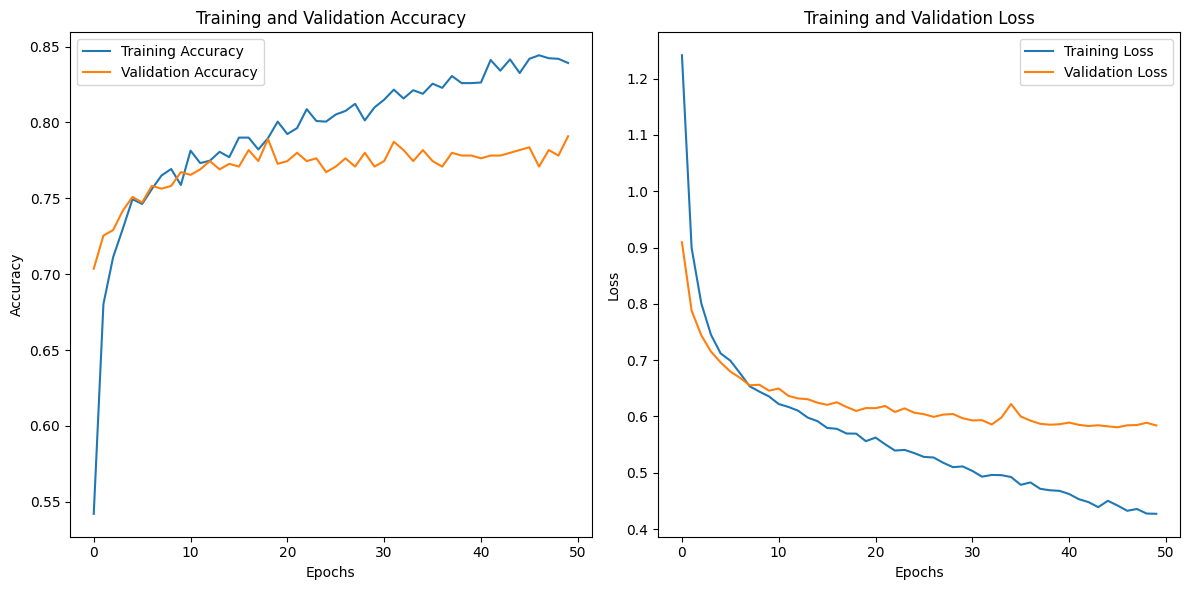

In [13]:
# Plotting training and validation accuracy
plt.figure(figsize=(12, 6))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


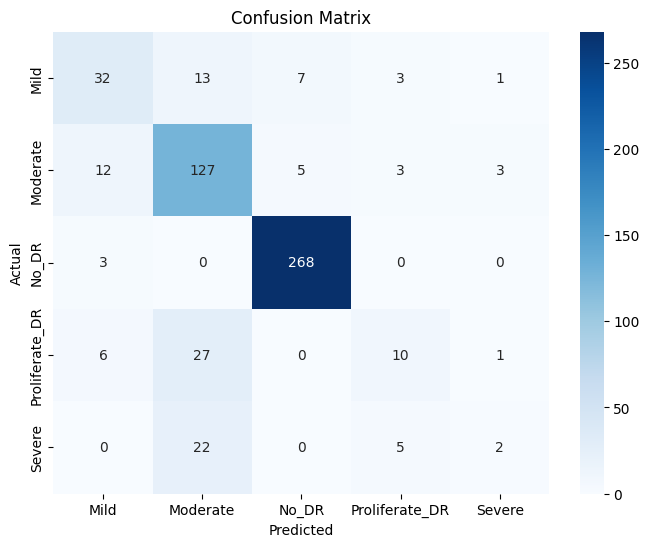

In [14]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Fungsi untuk mendapatkan prediksi dan label asli
def get_predictions(model, data_batches):
    # Menyimpan prediksi dan label asli
    y_true = []
    y_pred = []
    
    # Menyimpan label dan prediksi untuk seluruh dataset
    for i in range(len(data_batches)):
        batch = data_batches[i]
        images, labels = batch
        preds = model.predict(images)
        
        y_true.extend(np.argmax(labels, axis=1))  # Mengambil label asli
        y_pred.extend(np.argmax(preds, axis=1))   # Mengambil prediksi kelas
    
    return np.array(y_true), np.array(y_pred)

# Mendapatkan prediksi dan label asli dari dataset test
y_true, y_pred = get_predictions(model, test_batches)

# Menghitung confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Menampilkan confusion matrix dengan heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_batches.class_indices.keys(), yticklabels=test_batches.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


Precision, Recall, and F1-Score per Class:
                precision    recall  f1-score
Mild             0.603774  0.571429  0.587156
Moderate         0.671958  0.846667  0.749263
No_DR            0.957143  0.988930  0.972777
Proliferate_DR   0.476190  0.227273  0.307692
Severe           0.285714  0.068966  0.111111


<Figure size 1200x800 with 0 Axes>

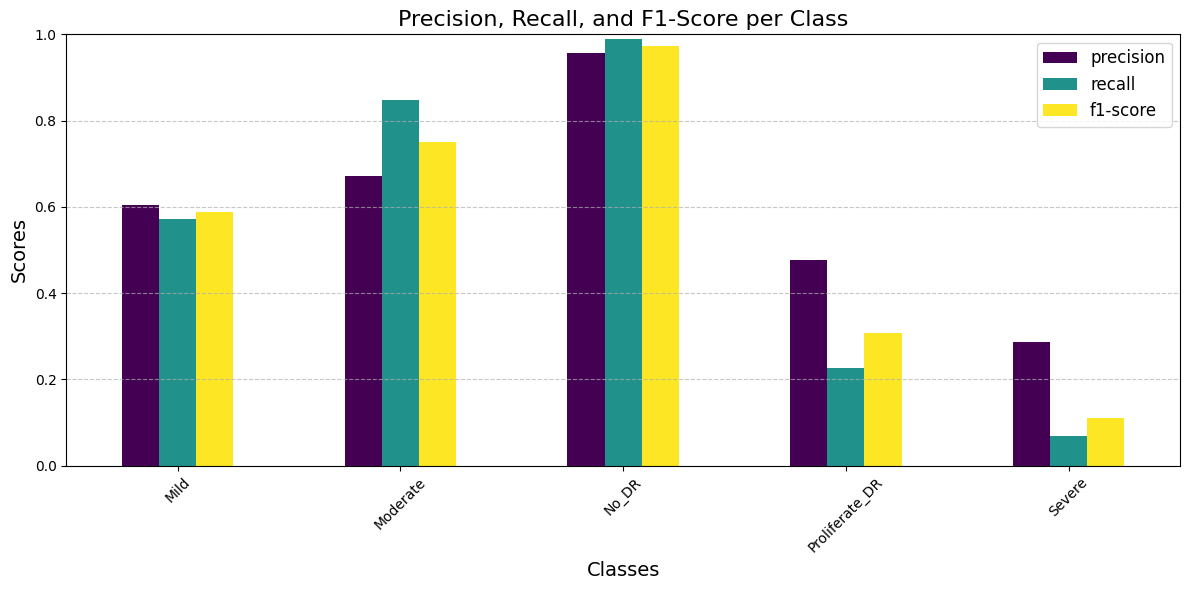

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
import pandas as pd

# Menghitung metrik menggunakan classification_report
report = classification_report(y_true, y_pred, target_names=test_batches.class_indices.keys(), output_dict=True)

# Konversi laporan ke DataFrame untuk kemudahan plotting
report_df = pd.DataFrame(report).transpose()

# Menghapus baris "accuracy", "macro avg", dan "weighted avg" (jika ingin hanya kelas)
metrics_df = report_df.drop(["accuracy", "macro avg", "weighted avg"])

# Print nilai precision, recall, dan f1-score per kelas
print("Precision, Recall, and F1-Score per Class:")
print(metrics_df[['precision', 'recall', 'f1-score']])

# Membuat plot untuk Precision, Recall, dan F1-Score
plt.figure(figsize=(12, 8))
metrics_df[['precision', 'recall', 'f1-score']].plot(kind='bar', figsize=(12, 6), colormap='viridis')

# Menambahkan label dan judul
plt.title('Precision, Recall, and F1-Score per Class', fontsize=16)
plt.xlabel('Classes', fontsize=14)
plt.ylabel('Scores', fontsize=14)
plt.xticks(rotation=45)
plt.ylim(0, 1)  # Karena metrik dalam rentang 0-1
plt.legend(loc='upper right', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Menampilkan plot
plt.tight_layout()
plt.show()


In [16]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Diagnosis dictionary
diagnosis_dict = {
    0: 'No_DR',
    1: 'Mild',
    2: 'Moderate',
    3: 'Severe',
    4: 'Proliferate_DR',
}

# Ensure the class mapping is correctly defined
class_mapping = {
    0: 1,  # No_DR → Mild
    1: 2,  # Mild → Moderate
    2: 0,  # Moderate → No_DR
    3: 4,  # Severe → Proliferate_DR
    4: 3,  # Proliferate_DR → Severe
}

# Function to predict class
def predict_class(path):
    # Load the image
    img = cv2.imread(path)

    # Convert BGR image to RGB and resize to (224, 224)
    RGBImg = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    RGBImg = cv2.resize(RGBImg, (224, 224))
    
    # Show the image
    plt.imshow(RGBImg)
    plt.axis('off')  # Hide the axes
    plt.show()

    # Preprocess the image (scale pixel values)
    image = np.array(RGBImg) / 255.0
    
    # Load the model
    new_model = tf.keras.models.load_model("model/model-multi.h5")
    
    # Predict the class
    predict = new_model.predict(np.array([image]))
    
    # Get the predicted class index
    predicted_class = np.argmax(predict, axis=1)[0]
    
    # Map the predicted class to the target class using class_mapping
    mapped_class = class_mapping[predicted_class]
    
    # Output the corresponding diagnosis
    print(f"Predicted Diagnosis: {diagnosis_dict[mapped_class]}")


In [17]:
import pickle

# Simpan model ke file .pkl
with open('model.pkl', 'wb') as f:
    pickle.dump(model, f)

print("Model saved to model.pkl")

Model saved to model.pkl


In [18]:
model.save('model/model-multi.h5')

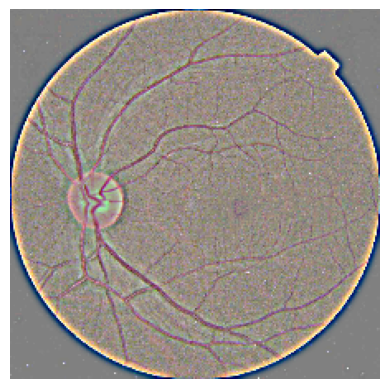

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted Diagnosis: No_DR


In [19]:
predict_class('dataset/diabetic-retinopathy-224x224-gaussian-filtered/No_DR/3bf3085ac167.png')